<a href="https://colab.research.google.com/github/aneeshcheriank/Advanced-vision/blob/main/Class_Activation_Map_Advance_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Activation Map

- what does the model looks at while categorizing an image into a category?

## Septs
- download pretrained vgg-16
- download images belongs to a class in the image-net
  - images of clocks
- create class activation map
- plot images


In [1]:
# import relevant libraries
import torch
from torchvision.models import vgg16
import cv2
from google.colab import files 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# download the vgg16 from torchvision
model = vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# Select a layer to find the class activation map
layer = nn.Sequential(
    *(list(model.features[:29].children()))
)

In [4]:
def image_process():
  # upload a set of images into colab from the pc
  # return tensor of images
  upload_files = files.upload()

  # read the uploaded files
  images = []
  for file in upload_files.keys():
    image = cv2.imread(file)
    image = cv2.cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    images.append(image)

  # convert the image to a tensor
  images = torch.tensor(images).float()
  images = images/255.

  return images

def heatmap(image):
  # take an image and find the heatmap curresponding to the activation of the image
  model.eval()
  logits = model(image.permute(0, 3, 1, 2))
  heatmap = []
  activations = layer(image.permute(0, 3, 1, 2))
  print(activations.shape)
  _, pred = logits.max(-1) # return both postion and values
  model.zero_grad()
  # compute the gradients wrt to models most confident logit
  logits[0, pred].backward(retain_graph=True)
  # need to find the mean over the channels
  grad = model.features[28].weight.grad.data.mean((0, 2, 3))
  # multiply each avctivation map with gradient average
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= grad[i] # shape (1: 512: 14: 14)
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()

  return heatmap, pred.item()

def resize_heatmap(map, img, size):
  min, max = map.min(), map.max()
  map = 255*((map - min)/(max-min))
  map = np.uint8(map)
  map = cv2.resize(map, (size, size))
  map = cv2.applyColorMap(map, cv2.COLORMAP_JET) # JET from BLUE -to- RED
  img = np.uint8(255*img)
  map = np.uint(map*0.7 + img*0.3)

  return map, img

Saving clock.jpeg to clock.jpeg
Saving clock 1.jpeg to clock 1.jpeg
Saving clock 2.jpeg to clock 2.jpeg
Saving clock 3.jpeg to clock 3.jpeg
Saving clock 4.jpeg to clock 4.jpeg
Saving clock 5.jpeg to clock 5.jpeg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  from ipykernel import kernelapp as app


torch.Size([1, 512, 14, 14])


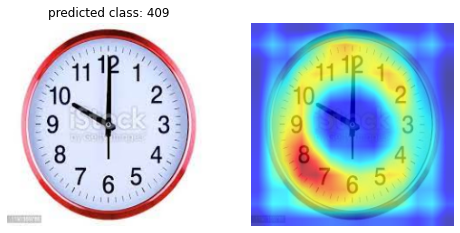

torch.Size([1, 512, 14, 14])


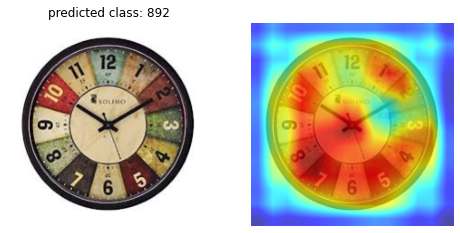

torch.Size([1, 512, 14, 14])


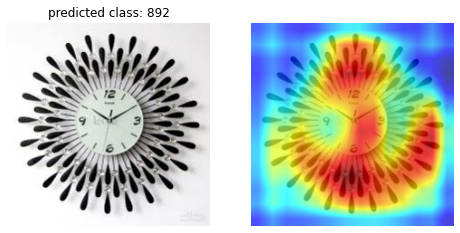

torch.Size([1, 512, 14, 14])


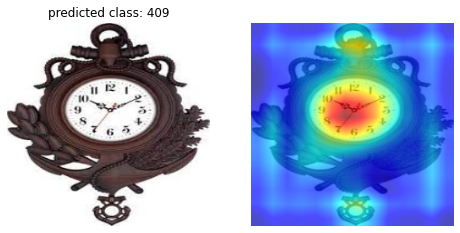

torch.Size([1, 512, 14, 14])


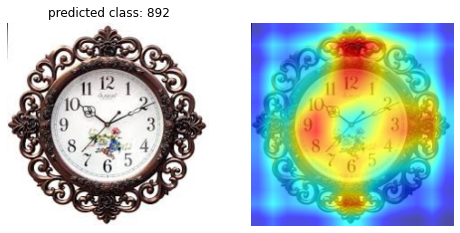

torch.Size([1, 512, 14, 14])


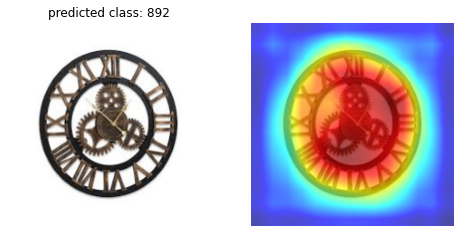

In [5]:
images = image_process()

# select the size
SZ = 224

for image in images:
  map, pred = heatmap(image[None, :, :, :])
  map, image = resize_heatmap(map, image, SZ)
  
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title(f'predicted class: {pred}')
  plt.axis(False)

  plt.subplot(1, 2, 2)
  plt.imshow(map)
  plt.axis(False)

  plt.show()
  

- Predicted Class
  - 409: Analogue clock
  - 892: Wall clock